# Glaze paper notes
[Glaze](https://arxiv.org/pdf/2302.04222.pdf) 

- perceptual pertubation budget: `p`
- impact of input perturbation: `alpha`
- Given artwork `x`
- feature exterator `phi`
- style-transferred version of x into target style `T:omega(x,T)`
- Style cloak `delta_x`
- Stable Diffusion provides both `epsilon` and `theta`

![Alt text](figures/glaze_eq1.png)

1) choose target style that is difrent than og artist style
2) transfer og artists images to new style using style transfer
3) compute cloak pertubation using [LPIPS](https://github.com/richzhang/PerceptualSimilarity)

![Alt text](figures/glaze_eq2.png)


# Implementing glaze paper
[HuggingFace stable diffusion pipleine](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py)

### Feature extractor
[CLIP](https://huggingface.co/docs/transformers/model_doc/clip)

[image_processing_clip](https://github.com/huggingface/transformers/blob/v4.26.1/src/transformers/models/clip/image_processing_clip.py#L45)

In [ ]:
%pip install Pillow
%pip install transformers
%pip install torch torchvision
%pip install git+https://github.com/openai/CLIP.git
%pip install matplotlib
%pip install lpips
%pip install diffusers
%pip install accelerate

Step 0: Loss = 0.18697360157966614
Step 1: Loss = 0.15650279819965363
Step 2: Loss = 0.1261226087808609
Step 3: Loss = 0.11022638529539108
Step 4: Loss = 0.10055152326822281
Step 5: Loss = 0.09279630333185196
Step 6: Loss = 0.08654819428920746
Step 7: Loss = 0.08164314925670624
Step 8: Loss = 0.0775626078248024
Step 9: Loss = 0.07387377321720123
Step 10: Loss = 0.07041016221046448
Step 11: Loss = 0.06712011992931366
Step 12: Loss = 0.06397861987352371
Step 13: Loss = 0.060944121330976486
Step 14: Loss = 0.05791812390089035
Step 15: Loss = 0.05486675351858139
Step 16: Loss = 0.0518290251493454
Step 17: Loss = 0.048844292759895325
Step 18: Loss = 0.04594175145030022
Step 19: Loss = 0.04317418485879898
Step 20: Loss = 0.04061730206012726
Step 21: Loss = 0.03835543245077133
Step 22: Loss = 0.03644920885562897
Step 23: Loss = 0.03487415984272957
Step 24: Loss = 0.033485159277915955
Step 25: Loss = 0.032115738838911057
Step 26: Loss = 0.030748415738344193
Step 27: Loss = 0.02950519695878029


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 999: Loss = 4.5133234380045906e-05


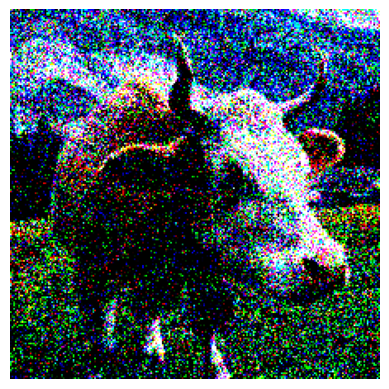

In [50]:
import torch
import torchvision.transforms as transforms
from clip import clip
import matplotlib.pyplot as plt
import torchvision.utils as vutils
from PIL import Image

# Load CLIP feature extractor and model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)
model.eval()

# Load images target and protect + perturbation
img_target = preprocess(Image.open('dog.png')).unsqueeze(0).to(device)
img_protect = preprocess(Image.open('cow.png')).unsqueeze(0).to(device)
perturbation = torch.randn_like(img_protect, requires_grad=True)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([perturbation], lr=0.01)

# Loop to adjust perturbation and minimize loss
for i in range(1000):
    # Compute features for img_target and img_protect + perturbation
    features_a = model.encode_image(img_target)
    features_b = model.encode_image(img_protect + perturbation)

    # Compute loss
    loss = criterion(features_a, features_b)
    # loss = torch.norm(features_a - features_b, p=2)

    # Zero gradients, compute gradients, and update perturbation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Step {i}: Loss = {loss.item()}')

# Apply perturbation to img_protect and save perturbed image
perturbed_img_protect = (img_protect + perturbation).squeeze(0).cpu()
# vutils.save_image(perturbed_img_protect, 'cow_dog.png')

# Display the image using matplotlib
# Convert the tensor image to a NumPy array
img_targetrray = perturbed_img_protect.detach().numpy().transpose(1, 2, 0)
plt.imshow(img_targetrray)
plt.axis('off')
plt.show()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/luc/Documents/glaze/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/luc/Documents/glaze/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
Step 0: Loss = 18.505352020263672
Step 1: Loss = 17.714359283447266
Step 2: Loss = 17.00623893737793
Step 3: Loss = 16.35664176940918
Step 4: Loss = 15.718436241149902
Step 5: Loss = 15.003311157226562
Step 6: Loss = 14.243986129760742
Step 7: Loss = 13.624258041381836
Step 8: Loss = 13.147302627563477
Step 9: Loss = 12.691056251525879
Step 10: Loss = 12.270049095153809
Step 11: Loss = 11.900398254394531
Step 12: Loss = 11.568275451660156
Step 13: Loss = 11.25222396850586
Step 14: Loss = 10.942411422729492
Step 15: Loss = 10.640155792236328
Step 16: Loss = 10.345575332641602
Step 17: Loss = 10.05495834350586
Step 18: Loss = 9.7610

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 999: Loss = 0.1290108859539032


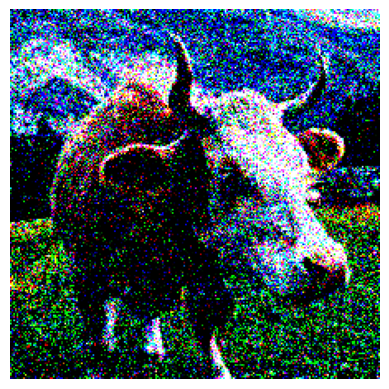

In [27]:
import lpips
import torch
import torchvision.transforms as transforms
from clip import clip
import matplotlib.pyplot as plt
from PIL import Image

# Load CLIP feature extractor and model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)
model.eval()

# Load images target and protect + perturbation
img_target = preprocess(Image.open('dog.png')).unsqueeze(0).to(device)
img_protect = preprocess(Image.open('cow.png')).unsqueeze(0).to(device)
perturbation = torch.randn_like(img_protect, requires_grad=True)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([perturbation], lr=0.01)

# Define penalty weight and lpips loss function
penalty_weight = 10
p = 0.05
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# Loop to adjust perturbation and minimize loss
for i in range(1000):
    # Compute features for img_target and img_protect + perturbation
    features_a = model.encode_image(img_target)
    features_b = model.encode_image(img_protect + perturbation)

    # Compute loss
    loss = torch.norm(features_a - features_b, p=2) + (penalty_weight * max(loss_fn_alex((img_protect + perturbation), img_protect) - p, 0))

    # Zero gradients, compute gradients, and update perturbation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Step {i}: Loss = {loss.item()}')

# Apply perturbation to img_protect and save perturbed image
perturbed_img_protect = (img_protect + perturbation).squeeze(0).cpu()
# vutils.save_image(perturbed_img_protect, 'cow_dog.png')

# Display the image using matplotlib
# Convert the tensor image to a NumPy array
img_targetrray = perturbed_img_protect.detach().numpy().transpose(1, 2, 0)
plt.imshow(img_targetrray)
plt.axis('off')
plt.show()

torch.Size([1, 3, 224, 224])
torch.FloatTensor
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /Users/luc/Documents/glaze/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/luc/Documents/glaze/.venv/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS loss: tensor([[[[16.6706]]]], grad_fn=<MulBackward0>)
Feature loss: 9.133831977844238
Step 0: Loss = 25.804431915283203
LPIPS loss: tensor([[[[16.1490]]]], grad_fn=<MulBackward0>)
Feature loss: 8.30203628540039
Step 1: Loss = 24.451034545898438
LPIPS loss: tensor([[[[15.8469]]]], grad_fn=<MulBackward0>)
Feature loss: 7.615644454956055
Step 2: Loss = 23.46249771118164
LPIPS loss: tensor([[[[15.6092]]]], grad_fn=<MulBackward0>)
Feature loss: 7.243956089019775
Step 3: Loss = 22.853200912475586
LPIPS loss: tensor([[[[15.4034]]]], grad_fn=<MulBackward0>)
Feature loss: 6.8299026489257

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


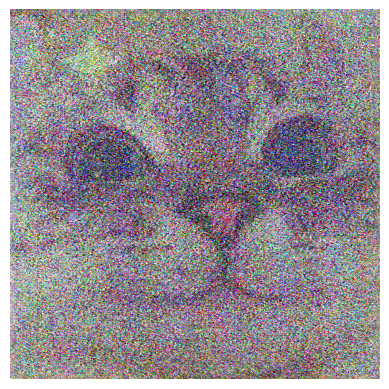

In [49]:
import lpips
import torch
import torchvision.transforms as transforms
from clip import clip
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import InterpolationMode

BICUBIC = InterpolationMode.BICUBIC

# From CLIP preprocessing
def _convert_image_to_rgb(image):
    return image.convert("RGB")

# Modified from CLIP preprocessing
def _transformImage(n_px):
    return transforms.Compose([
        # transforms.Resize(n_px, interpolation=transforms.BICUBIC),
        # transforms.CenterCrop(n_px),
        _convert_image_to_rgb,
        transforms.ToTensor(),
        # transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

# Modified from CLIP preprocessing
def _transformPerturbation(n_px):
    return transforms.Compose([
        transforms.Resize(n_px, interpolation=BICUBIC),
        transforms.CenterCrop(n_px),
        # _convert_image_to_rgb,
        # transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

# Load CLIP feature extractor and model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device=device)
model.eval()

# Define Transform and convert original image to tensor
transformImage = _transformImage(224)
transformPertubation = _transformPerturbation(224)
img_original = transformImage(Image.open('cat.png'))
perturbation = torch.randn_like(img_original, requires_grad=True)

# Load images target and protect + perturbation
img_target = preprocess(Image.open('cat_man.png')).unsqueeze(0).to(device)
img_protect = preprocess(Image.open('cat.png')).unsqueeze(0).to(device)
print(img_protect.shape)
print(img_protect.type())

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([perturbation], lr=0.01)

# Define penalty weight and lpips loss function
penalty_weight = 10
p = 0.05
loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# Loop to adjust perturbation and minimize loss
for i in range(1000):
    # Compute features for img_target and img_protect + perturbation
    features_a = model.encode_image(img_target)
    features_b = model.encode_image(img_protect + transformPertubation(perturbation))

    # Lpips loss
    lpips_loss = (penalty_weight * max(loss_fn_alex((img_original + perturbation), img_original) - p, 0))
    print(f'LPIPS loss: {lpips_loss}')

    # Feature loss
    feature_loss = torch.norm(features_a - features_b, p=2)
    print(f'Feature loss: {feature_loss}')

    # Compute loss
    loss = feature_loss + lpips_loss

    # Zero gradients, compute gradients, and update perturbation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f'Step {i}: Loss = {loss.item()}')

# Apply perturbation to img_original and save perturbed image
perturbed_img_original = (img_original + perturbation).squeeze(0).cpu()
vutils.save_image(perturbed_img_original, 'perturbed_demo.png')

# Display the image using matplotlib
# Convert the tensor image to a NumPy array
img_targetrray = perturbed_img_original.detach().numpy().transpose(1, 2, 0)
plt.imshow(img_targetrray)
plt.axis('off')
plt.show()